<a href="https://colab.research.google.com/github/henriquebap/Machine_Learning_HB/blob/main/Deep%20Q-Learning/CartPole-DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Treinamento Avancado do agente `CartPole`
## Reinforcement Learning utilizando o algoritmo DEep Q-Network (DQN) para aprender a equilibrar o poste no ambiente `CartPole`.
---
## Primeira versao e aprendendo a manipular parametros, gerenciar epochsde aprendizado e treinar em escala.
----
## Conceitos basicos de DQN
- Estados (States): Representações da situação atual do ambiente.
- Ações (Actions): Movimentos que o agente pode executar (p.ex., mover o carrinho para a esquerda ou direita).
- Recompensas (Rewards): Feedback recebido após executar uma ação, indicando a eficácia da ação.
- Política (Policy): Estratégia pela qual o agente seleciona ações com base nos estados.
- Função de Valor (Value Function): Avalia a qualidade das ações em estados específicos para maximizar as recompensas futuras.
---

### Codigo
- o Codigo de certa forma esta funcional, mas ainda ha muito que aprender e estudar sobre. existem varias versoes juntas e misturadas no ambiete, mas a ultima versao funcional nao esta comentada.

In [ ]:
!apt-get install -y xvfb python3-opengl ffmpeg
!pip install gym==0.23.1 stable-baselines3[extra]~=1.2.0 matplotlib

In [1]:
import gym
import numpy as np
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import os

In [32]:
# Função para criar o ambiente monitorado
def make_env():
    env = gym.make('CartPole-v1')
    env = Monitor(env)
    return env

# Envolver o ambiente com DummyVecEnv
env = DummyVecEnv([make_env])

# Verificar o Espaço de Ações
print("Espaço de Ações:", env.action_space)
print("Espaço de Observação:", env.observation_space)

# Definir o caminho para o modelo salvo
model_path = "/content/dqn_cartpole.zip"

# Criar e treinar o modelo DQN
try:
    model = DQN.load(model_path, env=env)
    print("Modelo Carregado")
except (FileNotFoundError, AssertionError, ValueError) as e:
    print(f"Erro ao carregar o modelo: {e}")
    model = DQN('MlpPolicy', env, verbose=0)
    print("Modelo Novo Criado")

mean_rewards = []
std_rewards = []

total_timesteps = 90000
for i in range(1, total_timesteps // 10000 + 1):
    model.learn(total_timesteps=10000, reset_num_timesteps=False)
    model.save(model_path)

    # Avaliar o agente
    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=5)
    print(f"Recompensa média após {i*10000} passos: {mean_reward} +/- {std_reward}")

    mean_rewards.append(mean_reward)
    std_rewards.append(std_reward)

model.save("dqn_cartpole_final")

Espaço de Ações: Discrete(2)
Espaço de Observação: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Erro ao carregar o modelo: Action spaces do not match: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32) != Discrete(2)
Modelo Novo Criado
Recompensa média após 10000 passos: 9.8 +/- 0.39999999999999997
Recompensa média após 20000 passos: 9.6 +/- 0.8
Recompensa média após 30000 passos: 9.4 +/- 0.4898979485566356
Recompensa média após 40000 passos: 9.6 +/- 0.48989794855663565
Recompensa média após 50000 passos: 9.0 +/- 0.6324555320336759
Recompensa média após 60000 passos: 9.4 +/- 0.7999999999999999
Recompensa média após 70000 passos: 9.4 +/- 0.48989794855663565
Recompensa média após 80000 passos: 85.6 +/- 20.981896959045432
Recompensa média após 90000 passos: 126.0 +/- 13.535139452550904


In [33]:
# Função para visualizar múltiplos episódios
def plot_cartpole_episodes(env, model, num_episodes=5, save_path='cartpole_episodes.mp4'):
    all_frames = []
    for episode in range(num_episodes):
        frames = []
        obs = env.reset()
        done = False
        while not done:
            frames.append(env.render(mode='rgb_array'))
            action, _states = model.predict(obs)
            obs, reward, done, info = env.step(action)
        all_frames.append(frames)

    def update_scene(num, all_frames, patch):
        episode, frame = divmod(num, len(all_frames[0]))
        patch.set_data(all_frames[episode][frame])
        return patch,

    fig = plt.figure()
    patch = plt.imshow(all_frames[0][0])
    plt.axis('off')
    ani = animation.FuncAnimation(fig, update_scene, fargs=(all_frames, patch),
                                  frames=sum(len(frames) for frames in all_frames), repeat=False)

    # Save animation to file
    writer = animation.FFMpegWriter(fps=30, codec='libx264')
    ani.save(save_path, writer=writer)


    return ani

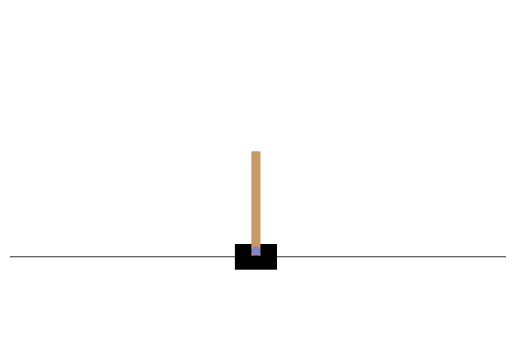

In [34]:
# Visualizar um episódio
env = make_env()  # Criar um ambiente para visualização, sem DummyVecEnv
ani = plot_cartpole_episodes(env, model, num_episodes=1, save_path='cartpole_single_episode.mp4')
HTML(ani.to_jshtml())

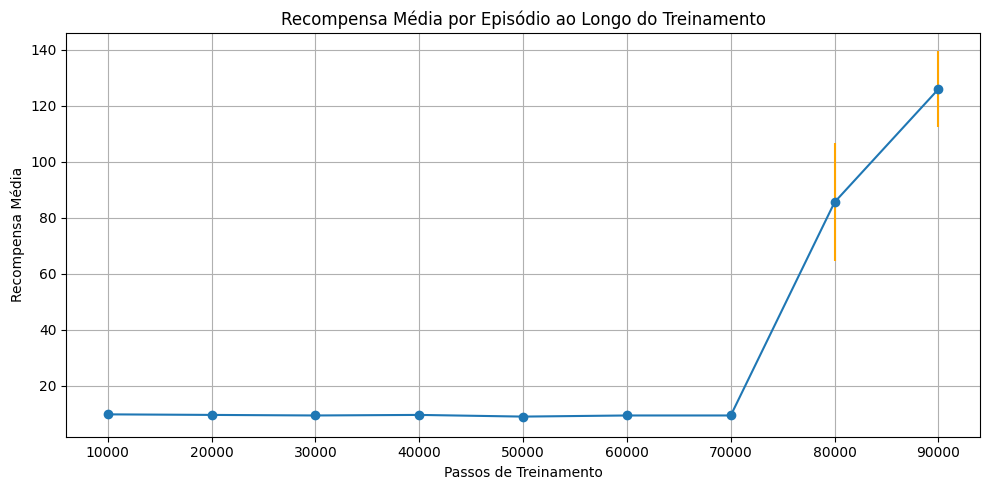

In [35]:
# Plotar a recompensa média ao longo do tempo
plt.figure(figsize=(10, 5))
plt.errorbar(np.arange(1, len(mean_rewards) + 1) * 10000, mean_rewards, yerr=std_rewards, fmt='-o', ecolor='orange')
plt.xlabel('Passos de Treinamento')
plt.ylabel('Recompensa Média')
plt.title('Recompensa Média por Episódio ao Longo do Treinamento')
plt.grid(True)
plt.tight_layout()
plt.show()